# Learn Actor Crititc

In [1]:
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt


import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".60"

# Optionally, force JAX to preallocate memory.
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Setup environment variable for Nvidia GPU acceleration
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True '
)
backend = 'gpu'
# backend = 'METAL'
# backend = 'cpu'

import jax
from jax import numpy as jp
import flax
import flax.linen as nn
import optax


# Enable compliation catch
jax.config.update("jax_compilation_cache_dir", "./jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", 0)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 5)
# jax.config.update("jax_explain_cache_misses", True)

# Debug Nan
jax.config.update("jax_debug_nans", False)


# More legible printing from numpy.
jp.set_printoptions(precision=4, suppress=True, linewidth=100)

import mujoco
import mujoco.mjx as mjx
from mujoco.mjx._src import scan
from mujoco.mjx._src import types

# More legible printing from numpy.
np.set_printoptions(precision=4, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

device = jax.devices(backend=backend)[0]

model_path = '../model/inverted_pendulum.xml'

# Single step
mjx_step = jax.jit(mjx.step, backend=backend)



# mjx_multiple_steps = jax.jit(multiple_steps, backend=backend, )

## Load Model

In [2]:
from mujoco.mjx._src.biomtu import acceleration_mtu

mj_model = mujoco.MjModel.from_xml_path(model_path)
mjx_model = mjx.put_model(mj_model,device=device)

# Disable tendon
opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
# mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
# mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
# mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)
mjx_data = mjx_step(mjx_model, mjx_data)

## Control Neural Network and Critic Neural Network
For now this NN will only work for the inverted pendulum

In [3]:

class Controller_NN(nn.Module):
    out_dims = 1
    def setup(self):
        # Features means the output dimension
        self.linear1 = nn.Dense(features=400)
        self.linear2 = nn.Dense(features=400)
        self.linear3 = nn.Dense(features=400)
        self.linear4 = nn.Dense(features=400)
        # The last layer will output the mean and logstd
        self.linear5 = nn.Dense(features=self.out_dims*2)
        
    
    def __call__(self, x, key):
        x = self.linear1(x)
        x = nn.relu(x)
        x = self.linear2(x)
        x = nn.relu(x)
        x = self.linear3(x)
        x = nn.relu(x)
        x = self.linear4(x)
        x = nn.relu(x)
        x = self.linear5(x)
        # The last layer of the neural requires samping
        mean = x[0]
        logstd = x[1]
        std = jp.exp(logstd)
        # samples = jp.clip(jax.random.normal(key)*std*0.3 + mean, -3, 3)
        samples = jax.random.normal(key)*std*0.3 + mean
        
        return samples, mean, logstd

# Test the neural network
controller = Controller_NN()

# Init the model
key = jax.random.key(2024)
sub_keys = jax.random.split(key,1)
# The second parameter is the dommy input
controller_params = controller.init(key,jp.empty([1, mjx_model.nq*2]),sub_keys[0])
# print(params)
jit_controller = jax.jit(lambda params, states, key : controller.apply(params, states, key))

class Critic_NN(nn.Module):

    def setup(self):
        # Features means the output dimension
        self.linear1 = nn.Dense(features=400)
        self.linear2 = nn.Dense(features=400)
        self.linear3 = nn.Dense(features=400)
        self.linear4 = nn.Dense(features=400)
        # The last layer will output the mean and logstd
        self.linear5 = nn.Dense(features=1)
        
    
    def __call__(self, x):
        x = self.linear1(x)
        x = nn.relu(x)
        x = self.linear2(x)
        x = nn.relu(x)
        x = self.linear3(x)
        x = nn.relu(x)
        x = self.linear4(x)
        x = nn.relu(x)
        x = self.linear5(x)
        # The last layer of the neural requires samping
        return -nn.relu(x)

critic = Critic_NN()

# Init the critic neural network by providing the input dummy. The input dummy defines the input shape
key = jax.random.split(sub_keys[0],1)[0]
sub_key = jax.random.split(key,1)[0]

# The input for the qcritic neural network should be observations and actions
# For the obs=mjx_model.nq*2, actions=1
critic_params = critic.init(key, jp.empty([1,mjx_model.nq*2]))
jit_critic = jax.jit(lambda params, state_acts: critic.apply(params, state_acts))

# Test the two neural networks
print(jit_controller(controller_params, jp.ones(mjx_model.nq*2), sub_keys[0]))
print(jit_critic(critic_params, jp.ones(mjx_model.nq*2)))


(Array(0.4321, dtype=float32), Array(0.1207, dtype=float32), Array(-0.1315, dtype=float32))
[-0.047]


## Experience Control

In [4]:
from dataclasses import dataclass
import functools


# Register the Experience class as pytree
@functools.partial(jax.tree_util.register_dataclass,
                   data_fields=['states', 'next_states', 'actions', 'rewards'],
                   meta_fields=[])
@dataclass
class Experience(object):
    states : jax.Array
    next_states : jax.Array
    actions : jax.Array
    rewards : jax.Array
    # dones: jax.Array
    
    # def __init__(self, state, next_state, action, reward):
    #     self.state = state
    #     self.next_state = next_state
    #     self.action = action
    #     self.reward = reward



@functools.partial(jax.tree_util.register_dataclass,
                   data_fields=['max_size', 'state_shape', 'action_shape', 'reward_shape'],
                   meta_fields=[])
@dataclass(frozen=True)
class Memory_settings():
    max_size     : jax.Array
    state_shape  : jax.Array
    action_shape : jax.Array
    reward_shape : jax.Array


class Memory(): 
    
    @staticmethod
    def append_fn(exp_item, exp_pool_item):
        return jp.concatenate([exp_item, exp_pool_item],axis=0)
    
    @staticmethod
    def trim_fn(exp_pool_item, length):
        return exp_pool_item[:length]
    
    @staticmethod
    def sample_fn(exp_pool_item, index):
        return exp_pool_item[index]
    
    staticmethod
    @functools.partial(jax.jit, static_argnames="settings")
    def add_exp(settings:Memory_settings, exp_pool:Experience, exp:Experience):
        exp.states = jp.reshape(exp.states,(-1, settings.state_shape))
        exp.next_states = jp.reshape(exp.next_states,(-1, settings.state_shape))
        exp.actions = jp.reshape(exp.actions, (-1, settings.action_shape))
        exp.rewards = jp.reshape(exp.rewards, (-1, settings.reward_shape))
        
        if(exp_pool == None):
            exp_pool = exp
        else:
            exp_pool = jax.tree.map(Memory.append_fn, exp, exp_pool)
            
        len = exp_pool.states.shape[0]
        
        # Forget the outdated memory
        if(len> settings.max_size):
            exp_pool = jax.tree.map(lambda x: Memory.trim_fn(x, settings.max_size), exp_pool)
        
        return exp_pool
        
    @staticmethod
    @functools.partial(jax.jit, static_argnames="batch_size")
    def sample(exp_pool, batch_size, key)-> Experience :
        index = jax.random.choice(
            key,
            jp.arange(exp_pool.states.shape[0]),
            shape = (batch_size,),
            replace=False
        )
        return jax.tree.map(lambda x: Memory.sample_fn(x, index), exp_pool)
        

## Multi-steps forward simulation

In [5]:
def step_fn(carry, _):
    data, model = carry
    new_data = mjx.step(model, data)
    new_carry = (new_data, model)
    return new_carry, _

def multiple_steps(model, data):
    init_carry = (data, model)
    y, _ = jax.lax.scan(step_fn, init_carry, None, length=10)
    new_data = y[0]
    return new_data

def nn_mjx_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel])
    act, mean, dev = jit_controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(ctrl = jp.array([act]))
    new_data = mjx.step(model, data)
    return new_data, new_key, act

@jax.jit
def jit_nn_mjx_one_step_no_random(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel])
    act, mean, dev = jit_controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(ctrl = jp.array([mean]))
    new_data = mjx.step(model, data)
    return new_data, new_key, mean

def nn_step_fn(carry, _):
    nn_params, model, data, key = carry
    new_data, new_key, act = nn_mjx_one_step(nn_params, model, data, key)
    new_carry = (nn_params, model, new_data, new_key)
    # Calculate reward
    state = jp.stack([data.qpos, data.qvel], axis=1).flatten()
    next_state = jp.stack([new_data.qpos, data.qvel], axis=1).flatten()
    action = act
    reward = -new_data.qpos[1]**2
    experience = Experience(state, next_state, action, reward)
    
    return new_carry, experience

def decay_sum_scan(x, decay):
    def f(sxtm1, xt):
        b = xt + decay * sxtm1
        return b, b
    return jax.lax.scan(f, jp.zeros(x.shape[1:]), x)[1]

@jax.jit
def jit_nn_multi_steps(nn_params, model, data, key):
    repeat_length = 5
    init_carry = (nn_params, model, data, key)
    y, experience = jax.lax.scan(nn_step_fn, init_carry, None, length=repeat_length)
    new_data = y[2]
    new_key = y[3]
    
    return new_data, new_key, experience

@jax.jit
def jit_v_nn_multi_steps(nn_params, model, data, key):
    return jax.vmap(jit_nn_multi_steps, in_axes=(None, None, 0, 0))(nn_params, model, data, key)

# This function generate
@jax.jit
def jit_vv_nn_multi_steps(nn_params, model, data, key):
    return jax.vmap(jit_v_nn_multi_steps, in_axes=(None, None, None, 1))(nn_params, model, data, key)

## Short Horizon Simulation & Gradient

## Environment Control 

In [6]:
# @jax.jit
def reset(model, batch_size):
    batch_dummy = jp.zeros(batch_size)
    v_make_data = jax.jit(jax.vmap(lambda model, batch_dummy: mjx.make_data(model), in_axes=(None,0),out_axes=0))
    new_datas = v_make_data(model, batch_dummy)
    return new_datas
    

## Visualize the model and controller

In [157]:
import mujoco.viewer
import time


mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)
previous_frame_time = time.time()
i = 0
key = jax.random.key(334)
with mujoco.viewer.launch_passive(mj_model, mj_data) as viewer:
    while viewer.is_running():
        # Update mjx_data from mj_data. The mj_data was modified by the viewer
        # mjx_data = mjx_data.replace(ctrl=mj_data.ctrl, xfrc_applied=mj_data.xfrc_applied)
        # Use the nerual network to generate ctrl signal
        # Generate key
        mjx_data = mjx_data.replace(xfrc_applied=jp.array(mj_data.xfrc_applied, dtype=jp.float32))
        mjx_data = mjx_data.replace(
            qpos= jp.array(mj_data.qpos, dtype=jp.float32),
            qvel= jp.array(mj_data.qvel, dtype=jp.float32),
            time = jp.array(mj_data.time, dtype=jp.float32))
        
        # Update mjx_model from mj_model
        mjx_model = mjx_model.tree_replace({
            'opt.gravity': jp.array(mj_model.opt.gravity, dtype=jp.float32),
            'opt.tolerance': jp.array(mj_model.opt.tolerance, dtype=jp.float32),
            'opt.ls_tolerance': jp.array(mj_model.opt.ls_tolerance, dtype=jp.float32),
            'opt.timestep': jp.array(mj_model.opt.timestep, dtype=jp.float32),
        })
        
        key = jax.random.split(key,1)[0]
        # mjx_data = mjx_step(mjx_model, mjx_data)
        # mjx_data, loss, exp = jit_nn_multi_steps(controller_params, mjx_model, mjx_data, key)
        mjx_data, key, act = jit_nn_mjx_one_step_no_random(controller_params, mjx_model, mjx_data, key)
        mjx.get_data_into(mj_data, mj_model, mjx_data)
        
        # Record the current time at the start of this frame
        current_frame_time = time.time()
    
        # Calculate the difference in time from the last frame
        time_between_frames = current_frame_time - previous_frame_time
    
        # Print the time between frames
        print(f"Time between frames: {time_between_frames} seconds")
        previous_frame_time = current_frame_time
        
        # print("ACT:", mjx_data.biomtu.act)
        # print(mjx_data.qpos)
        # print(mjx_data.sensordata)
        # print(len(mjx_data.qvel))
        viewer.sync()

Time between frames: 0.15021133422851562 seconds
Time between frames: 0.007979631423950195 seconds
Time between frames: 0.008025884628295898 seconds
Time between frames: 0.008130550384521484 seconds
Time between frames: 0.006911039352416992 seconds
Time between frames: 0.0066525936126708984 seconds
Time between frames: 0.0074231624603271484 seconds
Time between frames: 0.006432294845581055 seconds
Time between frames: 0.006772518157958984 seconds
Time between frames: 0.00892949104309082 seconds
Time between frames: 0.012923240661621094 seconds
Time between frames: 0.012794017791748047 seconds
Time between frames: 0.01041865348815918 seconds
Time between frames: 0.011100053787231445 seconds
Time between frames: 0.010301589965820312 seconds
Time between frames: 0.010606765747070312 seconds
Time between frames: 0.006689548492431641 seconds
Time between frames: 0.008092641830444336 seconds
Time between frames: 0.006643533706665039 seconds
Time between frames: 0.007639408111572266 seconds
T

## Test generate branch by stochastic policy neural network 

In [7]:
key = jax.random.key(1234)
memory_settings = Memory_settings(50000, 4, 1, 1)
exp_pool = None

In [173]:
# Let's generate some observations and rewards

def reshape_data(datas, batch_size, fock_size):
    def fn(data):
        new_shape = [*(data.shape)][1:]
        new_shape[0]=batch_size*fock_size
        # print(new_shape)
        return data.reshape(new_shape)
    return jax.tree.map(fn,datas)



init_batch_size = 10
batch_size = init_batch_size
fock_size = 10

# Start with the fixed init state
keys = jax.random.split(key, batch_size)
datas = reset(mjx_model,batch_size)


# print(datas.qpos)
for i in range(10):    # For 2 seconds
    datas, keys, exp = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    if(i == 2):    # After 0.5 seconds fock the simulation
        keys = jax.vmap(jax.random.split, in_axes=(0,None))(keys, fock_size)
        datas, keys, exp = jit_vv_nn_multi_steps(controller_params, mjx_model, datas, keys)
        keys = keys.reshape(batch_size*fock_size)
        datas = reshape_data(datas, batch_size, fock_size)
        exp = reshape_data(exp, batch_size, fock_size)
        # print(datas.qvel.shape, datas.ten_J.shape)
        batch_size = batch_size*fock_size
    exp_pool = Memory.add_exp(memory_settings, exp_pool, exp)

(50000, 4)
(100, 2)
(100, 2)


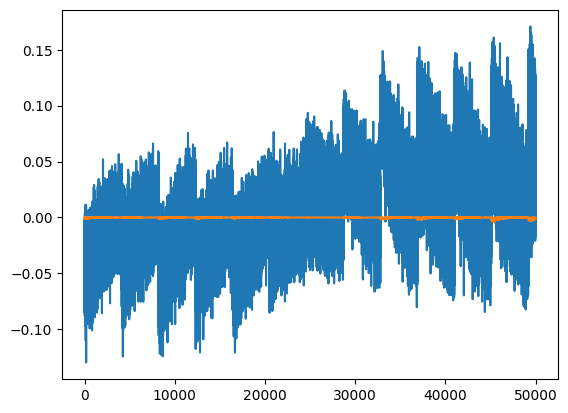

In [174]:
import matplotlib.pyplot as plt
# print(exp_pool)
print(exp_pool.states.shape)
key = jax.random.split(key, 1)[0]
batch = Memory.sample(exp_pool, 100, key)
key = jax.random.split(key, 1)[0]
print(batch.states[:,0:2].shape)
print(datas.qpos.shape)
plt.plot(exp_pool.states.T[1])
plt.plot(exp_pool.rewards)

## Train the critic neural network with generated data


In [10]:

import flax.linen


v_critic = jax.vmap(critic.apply,in_axes=(None, 0))


def critic_loss(params, batch):
    discount = 0.95
    states = batch.states
    next_states = batch.next_states
    actions = batch.actions
    rewards = batch.rewards
    
    critic_score = v_critic(params, states)
    target = rewards + discount* critic.apply(params, next_states)
    
    loss = optax.l2_loss(critic_score, target)
    loss = jp.mean(loss)
    return loss
    
jit_critic_loss_value = jax.jit(jax.value_and_grad(critic_loss))
    

In [ ]:
# Reset Critic_NN parameters
critic_params = critic.init(key, jp.empty([1,mjx_model.nq*2]))
tx = optax.adam(learning_rate=0.00002)
opt_state = tx.init(critic_params)
jit_tx_update = jax.jit(tx.update)
jit_apply_update = jax.jit(optax.apply_updates)


In [175]:

for i in range(2000):
    batch = Memory.sample(exp_pool, 40, key)
    key = jax.random.split(key, 1)[0]
    loss, loss_grad = jit_critic_loss_value(critic_params, batch)
    print(loss)
    # Update params
    updates, opt_stats = jit_tx_update(loss_grad, opt_state)
    critic_params = jit_apply_update(critic_params, updates)
    

5.2059006e-09
7.253749e-09
2.3176217e-08
1.5949361e-08
6.981329e-09
1.3357202e-08
6.84129e-09
5.5467178e-09
7.540989e-09
7.73889e-09
1.8783886e-08
5.8320295e-09
7.12424e-09
1.3012751e-08
1.0151804e-08
8.943726e-09
6.1252963e-09
9.607688e-09
2.3886978e-08
1.5255484e-08
1.6464327e-08
1.5520445e-08
7.687945e-09
9.271721e-09
6.935655e-09
1.345419e-08
1.7835088e-08
1.2427319e-08
7.1372357e-09
1.093436e-08
1.7973647e-08
4.1984705e-09
1.769264e-08
9.120298e-09
1.08579625e-08
5.487157e-09
8.1215505e-09
7.2664648e-09
1.0149636e-08
1.2401671e-08
1.2569127e-08
5.7033094e-09
1.8973637e-08
1.0258041e-08
1.1356746e-08
9.589999e-09
5.68514e-09
1.08339675e-08
1.1099821e-08
1.40922465e-08
1.3758532e-08
1.5077122e-08
1.4482197e-08
9.2193355e-09
8.849947e-09
8.213735e-09
1.2508678e-08
8.730574e-09
5.033643e-09
1.2547488e-08
5.0198965e-09
1.206178e-08
1.1397711e-08
8.137221e-09
1.5522138e-08
7.653486e-09
4.888315e-09
5.928443e-09
7.191932e-09
6.8255988e-09
1.3573836e-08
5.5058536e-09
8.88367e-09
1.3183441

### Test the critic neural network

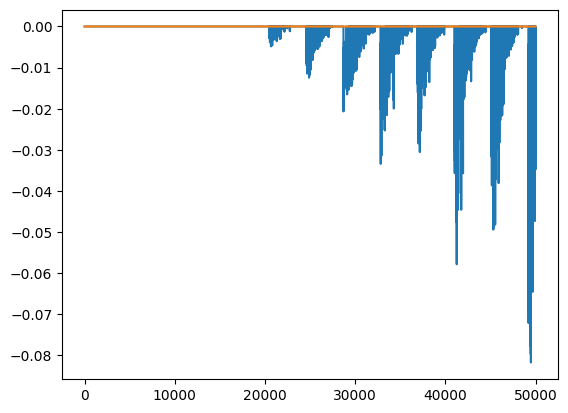

In [167]:
jit_v_critic = jax.jit(v_critic)
test_states = exp_pool.states

# test_states = test_states.at[:,0].set(jp.zeros(test_states.shape[0]))
test_states = test_states.at[:,1].set(jp.zeros(test_states.shape[0]))
test_states = test_states.at[:,2].set(jp.zeros(test_states.shape[0]))
test_states = test_states.at[:,3].set(jp.zeros(test_states.shape[0]))
scores = jit_v_critic(critic_params, exp_pool.states)
test_scores = jit_v_critic(critic_params, test_states)

plt.plot(scores)
plt.plot(test_scores)

## Train the controller with the critic net without the differentiable simulator

In [14]:
# Reset Params
controller_params = controller.init(key,jp.empty([1, mjx_model.nq*2]),sub_keys[0])
tx = optax.adam(learning_rate=0.00001)
opt_state = tx.init(controller_params)
jit_tx_update = jax.jit(tx.update)
jit_apply_update = jax.jit(optax.apply_updates)
batch_size = 400
# Init data


In [15]:
v_controller = jax.vmap(controller.apply,in_axes=(None, 0))


def total_loss(controller_params, critic_params, batch, batch_size, mjx_model, keys):
    # batch_size = batch.states.shape[0]
    states = batch.states
    # Generate data for simulation
    in_data = reset(mjx_model, batch_size).replace(qpos = states[:,0:2], qvel = states[:,2:4])
    out_data, keys, exp = jit_v_nn_multi_steps(controller_params, mjx_model, in_data, keys)
    out_states = jp.stack([out_data.qpos, out_data.qvel], axis=1).reshape(batch_size,4)
    # jax.debug.print("out_states shape{0}", out_states.shape)
    critic_score = v_critic(critic_params, out_states)
    
    loss = -jp.mean(critic_score)
    return loss

jit_total_loss_grad_value = jax.jit(jax.value_and_grad(total_loss), static_argnames=["batch_size"])

# Test total_lose
# batch_size = 100
# batch = Memory.sample(exp_pool, batch_size, key)
# key = jax.random.split(key, 1)[0]
# keys = jax.random.split(key,batch_size)
# jit_total_loss = jax.jit(total_loss, static_argnames=["batch_size"])
# loss, grad = jit_total_loss_grad_value(controller_params, critic_params, batch, batch_size, mjx_model, keys)
# print(loss)

In [180]:
new_params = controller_params
for i in range(100):
    batch = Memory.sample(exp_pool, batch_size, key)
    key = jax.random.split(key, 1)[0]
    keys = jax.random.split(key,batch_size)
    loss, loss_grad = jit_total_loss_grad_value(new_params, critic_params, batch, batch_size, mjx_model, keys)
    print(loss)
    # Update params
    updates, opt_stats = jit_tx_update(loss_grad, opt_state)
    new_params = jit_apply_update(new_params, updates)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [179]:
controller_params = new_params

## Train the controller with the critic net and the differentiable simulator

## Short Horizon Gradient calculation

In [ ]:
def change_shape(x):
    # print(x.shape)
    return x.reshape(batch_size*fock_size,-1) 
d = jax.tree.map(change_shape,datas)
print(d.qpos.shape)
print(datas.qpos.shape)


In [ ]:
print(keys.shape)
kk = jax.vmap(jax.random.split, in_axes=(0,None))(keys, 5)
print(kk.shape)
k = jp.reshape(kk, jp.array(kk.shape))
print(k.shape)

[*kk.shape][1:]
# print(kk.shape)

## Learn To generate Critic Neural Network

In [ ]:
datas.qpos.shape
b = jp.stack([datas.qpos, datas.qvel], axis=1).reshape(datas.qpos.shape[0],-1)
print(b[0])
print(datas.qpos[0])
print(b.shape)

In [ ]:
a = [[2,3,4]]
b = [6,7]
b += a
print(b)

In [ ]:
jp.stack([datas.qpos, datas.qvel], axis=1).reshape(100,-1).shape

(100, 4)